<a href="https://colab.research.google.com/github/gopalam/Computational_Geometry/blob/main/MIIST_OPS/MIIST_OPS_RootsRX_PredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic time series model that takes in daily variables of data for each store and develops a prediction model.
Some notes:
The model looks to develop prediction for each variable in the dataset.
A Vector Autoregression (VAR) type model is chosen which assumes that on paper
every variable in the dataset is influenced by evry other variable  ie. two way influence. The degree of influence may vary, and is used to cull down the variabl set for each model

VAR Model - basics

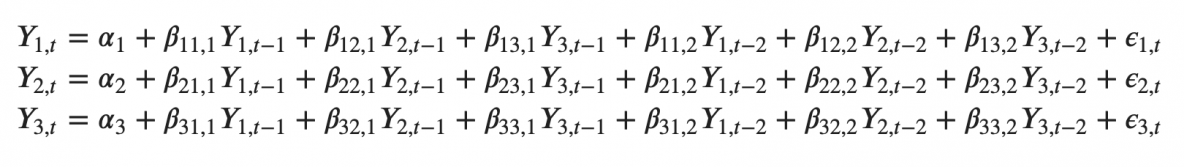

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**useful functions all pulled into the beginning of code. skip these to go straight to plots and results**

In [2]:
"""**Check for Stationarity in data using the  Augmented Dickey-Fuller Test**"""

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=14
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var  for var in variables]
    df.index = [var  for var in variables]
    return df


Read the data. Data posted has time latest time stamps first, so flip the time variable and the data.

In [3]:
Store="Basalt"

In [5]:

filepath= r'https://raw.githubusercontent.com/gopalam/KnoWhere/main/MIIST_OPS/RootsRXBasalt-Sales-20210828-20211205.csv?token=ACDDSYQQNEGZMOYV7MZIODTB2ZVJK'

df0 = pd.read_csv(filepath, parse_dates=['date'], index_col='date')

# filepath = 'RootsRXBasalt-Sales-20210828-20211205.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
df=df.iloc[::-1]
df

(100, 6)


,transactionCount,totalUnitsSold,discountedUnitsSold,netSales,netCost,netDiscountedValue
date,,,,,,
2021-08-28,146,444.59,115.00,969368.27,507800.58,109241
2021-08-29,130,427.04,94.48,788565.34,404684.28,55199
2021-08-30,151,511.36,126.00,1073249.73,511985.89,49360
2021-08-31,168,470.04,85.00,749009.24,372280.43,76249
2021-09-01,174,509.60,161.00,799104.46,415355.50,81339
...,...,...,...,...,...,...
2021-12-01,126,405.54,106.00,768490.84,377019.22,89363
2021-12-02,131,466.92,135.00,832675.39,416594.11,97236
2021-12-03,143,417.39,108.00,835017.10,409665.96,63808


# Initial Analysis
 **Basic plots of time series to see if there are any trends.  
Plots show that data mostly is a function of fluctuations+ trend
Data =Linear Trend+ daily fluctuation**

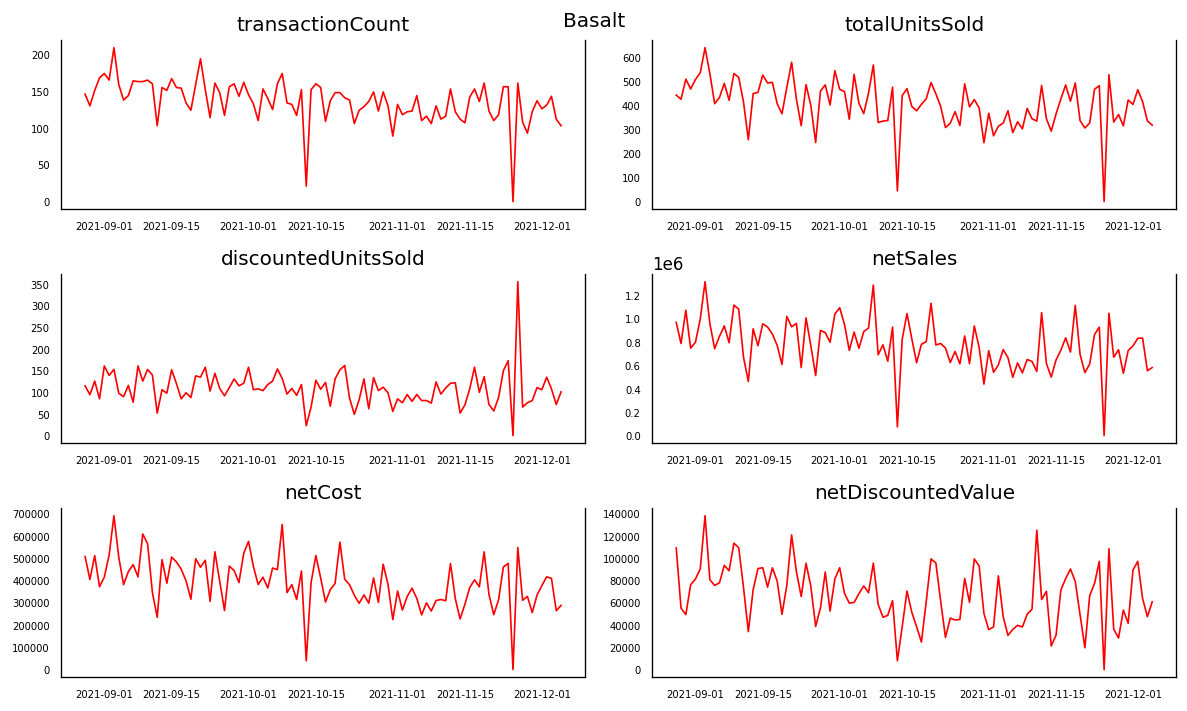

In [6]:
#time series plots
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

fig.suptitle('Basalt')
plt.tight_layout();


**Pairwise regresssions of the plot. Data shows some good structure, and inter-relatonships between variables. So, VAR model is a suitable candidate.**

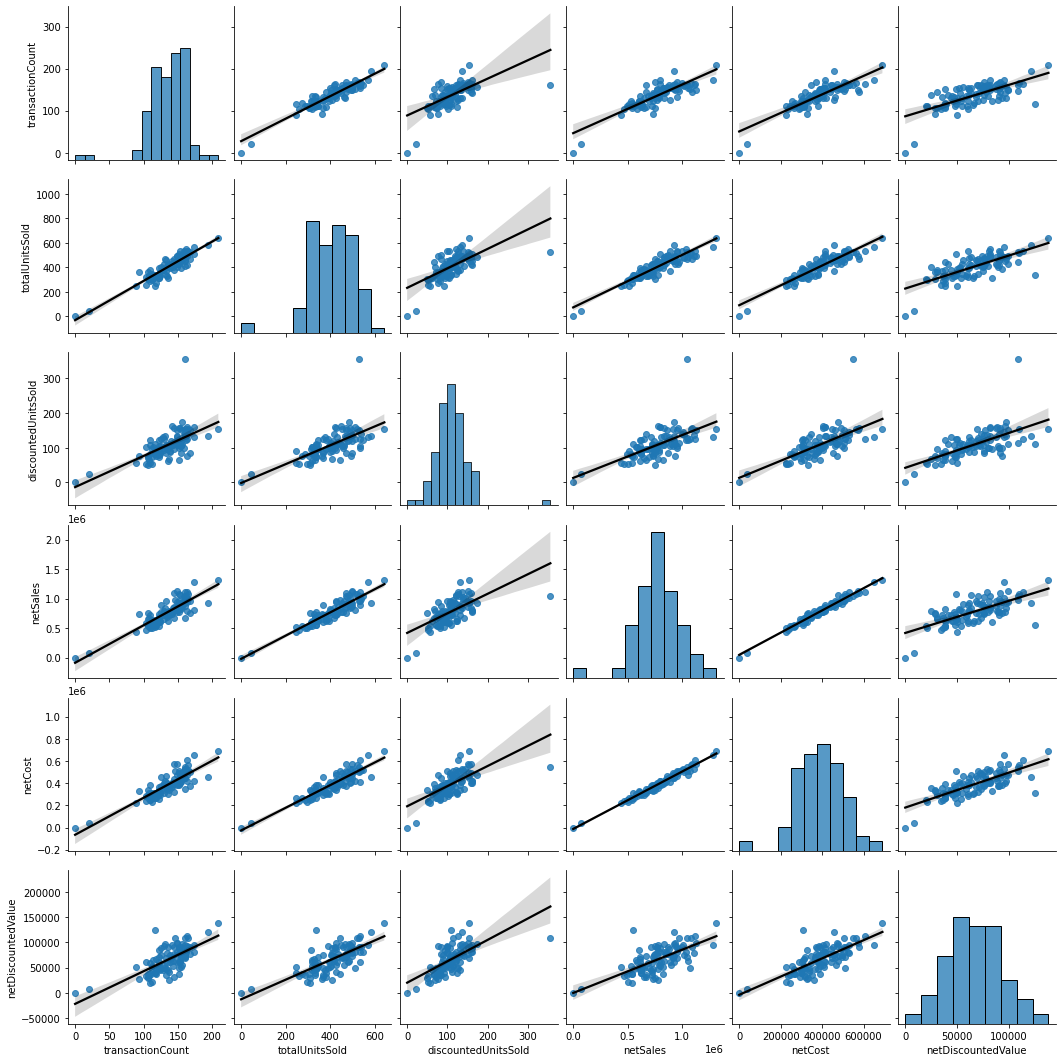

In [7]:
# scatter plot of pairwise regression

sns.pairplot(df, kind="reg", plot_kws={'line_kws':{'color':'black'}})



# Make Data Stationary
**Time series data needs to be stationary . We see a linear trend in the data. So we are detrending and developing the model on the detrended data**

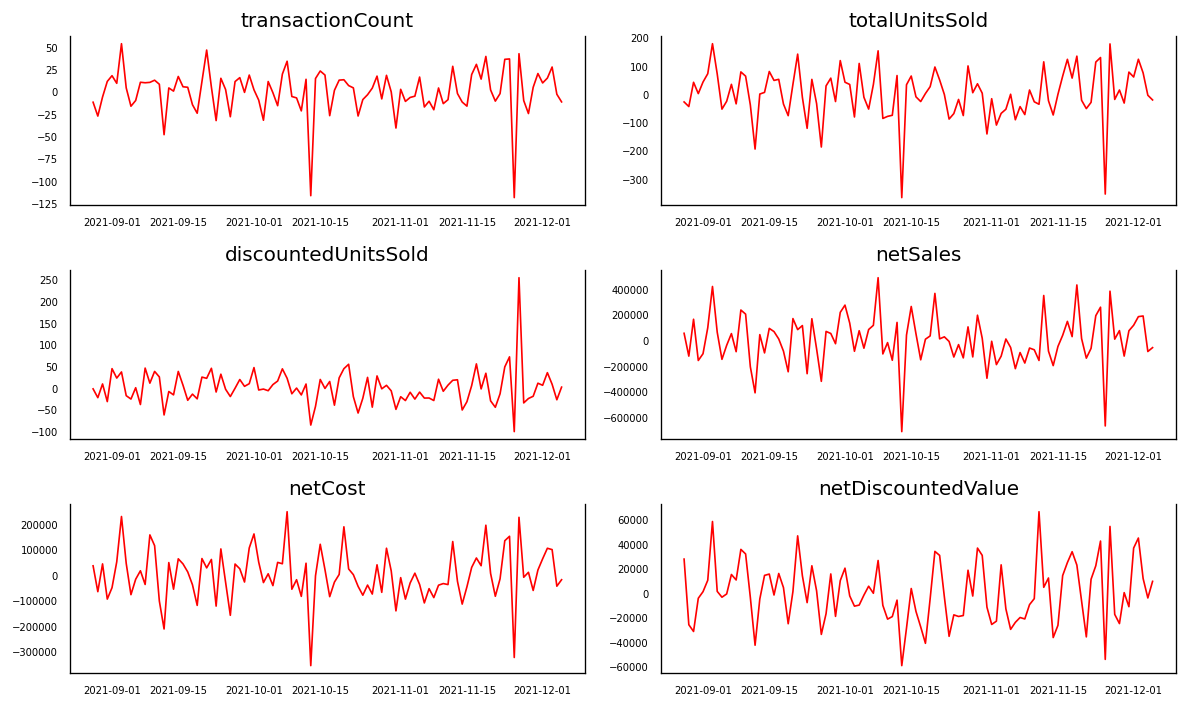

In [8]:
# detrend data
df_new=df.copy();
from sklearn.linear_model import LinearRegression

X = [i for i in range(0, len(df))]
X = np.reshape(X, (len(X), 1))
y = df.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
df_trend=df.copy();
cols=['transactionCount', 'totalUnitsSold', 'discountedUnitsSold', 'netSales', 'netCost', 'netDiscountedValue']
for i in range(0,len(cols)):
    df_new.at[:,cols[i]]=df[cols[i]]-trend[:,i]
    df_trend.at[:,cols[i]]=trend[:,i]

# plot detrended
# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_new[df_new.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


**Check for Stationarity in data using the  Augmented Dickey-Fuller Test**

In [9]:
for name, column in df_new.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')       


    Augmented Dickey-Fuller Test on "transactionCount" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.7455
 No. Lags Chosen       = 1
 Critical value 1%     = -3.499
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "totalUnitsSold" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4319
 No. Lags Chosen       = 0
 Critical value 1%     = -3.498
 Critical value 5%     = -2.891
 Critical value 10%    = -2.583
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "discountedUnitsSold" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stat

#  Granger causality test
**Do a Granger causality test to see if all variables have an influence on all the remaining variables**
The results show that some variables can be explained with a narrower set of variables.But the model proceeds to use all variables. This needs to be changed later

In [10]:
# Do a Granger causality test
grng=grangers_causation_matrix(df_new, variables = df_new.columns)
grng.head(10)


,transactionCount,totalUnitsSold,discountedUnitsSold,netSales,netCost,netDiscountedValue
transactionCount,1.0000,0.0590,0.3128,0.0080,0.0120,0.0063
totalUnitsSold,0.1044,1.0000,0.1746,0.0014,0.0001,0.0000
discountedUnitsSold,0.2667,0.6433,1.0000,0.3258,0.4208,0.0008
netSales,0.0535,0.0175,0.3145,1.0000,0.0037,0.0019
netCost,0.0538,0.0005,0.0628,0.0114,1.0000,0.0053
netDiscountedValue,0.1092,0.0269,0.0084,0.2502,0.2002,1.0000


# Model Selection
We use the results of Granger causality to recruit candidate variables for each variable. For each variable choose only those variables that qualify with p<0.05


In [11]:
#create a filter DF
candidate_vars_filter=grng<0.05
candidate_vars_filter


,transactionCount,totalUnitsSold,discountedUnitsSold,netSales,netCost,netDiscountedValue
transactionCount,False,False,False,True,True,True
totalUnitsSold,False,False,False,True,True,True
discountedUnitsSold,False,False,False,False,False,True
netSales,False,True,False,False,True,True
netCost,False,True,False,True,False,True
netDiscountedValue,False,True,True,False,False,False


In [12]:
candidate_vars=pd.DataFrame(index=candidate_vars_filter.index)
candidate_vars['var_list']=str('')
candidate_vars


,var_list
transactionCount,
totalUnitsSold,
discountedUnitsSold,
netSales,
netCost,
netDiscountedValue,


# **Variable selection for models**
We have six variables, and each variable has a different set of driver variables. We use the p-test to pick the ones given by this test, in addition to the variable itself (i.e each variable's own past data is also a part of the model)

In [16]:
#%% now try to do a selection of variables based on True condition
from itertools import compress
for i in range (0,len(candidate_vars_filter)):
   
    filt=candidate_vars_filter.loc[cols[i]].tolist()
    ind_var=cols[i]
    # filter to get animating vars
    vrs=list(compress(cols, filt))
    # prepend the original variable
    vrs.insert(0, ind_var)
    print('Variable',cols[i],'==> Model :',vrs)
    
    if (i==0):
        df1_full=df[vrs]
        df1=df_new[vrs]
        df1_trend=df_trend[vrs]
    if (i==1):
        df2_full=df[vrs]
        df2=df_new[vrs]
        df2_trend=df_trend[vrs]
    if (i==2):
        df3_full=df[vrs]
        df3=df_new[vrs]
        df3_trend=df_trend[vrs]
    if (i==3):
        df4_full=df[vrs]
        df4=df_new[vrs]
        df4_trend=df_trend[vrs]
    if (i==4):
        df5_full=df[vrs]
        df5=df_new[vrs]
        df5_trend=df_trend[vrs]
    if (i==5):
        df6_full=df[vrs]
        df6=df_new[vrs]
        df6_trend=df_trend[vrs]


Variable transactionCount ==> Model : ['transactionCount', 'netSales', 'netCost', 'netDiscountedValue']
Variable totalUnitsSold ==> Model : ['totalUnitsSold', 'netSales', 'netCost', 'netDiscountedValue']
Variable discountedUnitsSold ==> Model : ['discountedUnitsSold', 'netDiscountedValue']
Variable netSales ==> Model : ['netSales', 'totalUnitsSold', 'netCost', 'netDiscountedValue']
Variable netCost ==> Model : ['netCost', 'totalUnitsSold', 'netSales', 'netDiscountedValue']
Variable netDiscountedValue ==> Model : ['netDiscountedValue', 'totalUnitsSold', 'discountedUnitsSold']


**Write training and validation datasets seperately for both detrended and original data. We use 86 ( 86 days) of data for training, and 14 days for validation.**

In [17]:
# get a training dataset and validation dataset
# get a training dataset and validation dataset, this data is detrended
nobs = 14
df1_train, df1_test = df1[0:-nobs], df1[-nobs:]
df2_train, df2_test = df2[0:-nobs], df2[-nobs:]
df3_train, df3_test = df3[0:-nobs], df3[-nobs:]
df4_train, df4_test = df4[0:-nobs], df4[-nobs:]
df5_train, df5_test = df5[0:-nobs], df5[-nobs:]
df6_train, df6_test = df6[0:-nobs], df6[-nobs:]
# get a training dataset and validation dataset, this data is NOT detrended
# used for plots and forecast
nobs = 14
df1_train_full, df1_test_full = df1_full[0:-nobs], df1_full[-nobs:]
df2_train_full, df2_test_full = df2_full[0:-nobs], df2_full[-nobs:]
df3_train_full, df3_test_full = df3_full[0:-nobs], df3_full[-nobs:]
df4_train_full, df4_test_full = df4_full[0:-nobs], df4_full[-nobs:]
df5_train_full, df5_test_full = df5_full[0:-nobs], df5_full[-nobs:]
df6_train_full, df6_test_full = df6_full[0:-nobs], df6_full[-nobs:]



In [18]:
#fit the VAR model
data = {'Lag': [1,3,5,7,10,13,14],
        'model1': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
        'model2': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
        'model3': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
        'model4': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
        'model5': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
        'model6': [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
        }

AIC_df=pd.DataFrame(data)
AIC_df

,Lag,model1,model2,model3,model4,model5,model6
0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,3,NaN,NaN,NaN,NaN,NaN,NaN
2,5,NaN,NaN,NaN,NaN,NaN,NaN
3,7,NaN,NaN,NaN,NaN,NaN,NaN
4,10,NaN,NaN,NaN,NaN,NaN,NaN
5,13,NaN,NaN,NaN,NaN,NaN,NaN
6,14,NaN,NaN,NaN,NaN,NaN,NaN


Capture model AIC values for different lag values. 

In [19]:

model1 = VAR(df1)
model2 = VAR(df2)
model3 = VAR(df3)
model4 = VAR(df4)
model5 = VAR(df5)
model6 = VAR(df6)

j=0
for i in [1,3,5,7,10,13,14]:
    r1 = model1.fit(i)
    r2 = model2.fit(i)
    r3 = model3.fit(i)
    r4 = model4.fit(i)
    r5 = model5.fit(i)
    r6 = model6.fit(i)
    AIC_df.at[j,'model1']=r1.aic
    AIC_df.at[j,'model2']=r2.aic
    AIC_df.at[j,'model3']=r3.aic
    AIC_df.at[j,'model4']=r4.aic
    AIC_df.at[j,'model5']=r5.aic
    AIC_df.at[j,'model6']=r6.aic
    j=j+1
    
AIC_df
        


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

,Lag,model1,model2,model3,model4,model5,model6
0,1,68.211312,70.124573,27.050137,70.124573,70.124573,35.281459
1,3,68.386980,70.319899,27.139463,70.319899,70.319899,35.465210
2,5,68.467686,70.551668,27.257786,70.551668,70.551668,35.578424
3,7,68.620591,70.707214,27.249335,70.707214,70.707214,35.655179
4,10,68.802279,70.906041,27.494923,70.906041,70.906041,35.986346
5,13,68.100225,70.740191,27.448481,70.740191,70.740191,35.863150
6,14,67.989939,70.707904,27.571371,70.707904,70.707904,35.973053


highlight data for one model

In [ ]:
m1 = model1.select_order(maxlags=14)
m1.summary()

,AIC,BIC,FPE,HQIC
0,68.10,68.21*,3.760e+29*,68.15*
1,68.30,68.87,4.582e+29,68.53
2,68.40,69.43,5.111e+29,68.82
3,68.59,70.07,6.179e+29,69.18
4,68.87,70.81,8.296e+29,69.65
5,68.69,71.09,7.053e+29,69.65
6,68.77,71.62,7.885e+29,69.92
7,68.79,72.10,8.343e+29,70.12
8,68.80,72.57,8.922e+29,70.31
9,68.80,73.02,9.602e+29,70.50


fit the model and capture equations

In [21]:
model1_fitted = model1.fit(14)
model2_fitted = model2.fit(14)
model3_fitted = model3.fit(14)
model4_fitted = model4.fit(14)
model5_fitted = model5.fit(14)
model6_fitted = model6.fit(14)


#Durbin Watson statistic of serial correlations

In [22]:
#Durbin Watson statistic of serial correlations

from statsmodels.stats.stattools import durbin_watson

out1= durbin_watson(model1_fitted.resid)
out2= durbin_watson(model2_fitted.resid)
out3= durbin_watson(model3_fitted.resid)
out4= durbin_watson(model4_fitted.resid)
out5= durbin_watson(model5_fitted.resid)
out6= durbin_watson(model6_fitted.resid)

print('----------------Values should not be too close to 4---------------')

print('----------------model1-transactionCount--------------')
for col, val in zip(df1.columns, out1):
    print(col, ':', round(val, 2))
print('----------------model2-totalUnitsSold--------------')
for col, val in zip(df2.columns, out2):
    print(col, ':', round(val, 2))    
print('----------------model1-discountedUnitsSold--------------')
for col, val in zip(df3.columns, out3):
    print(col, ':', round(val, 2))
print('----------------model2-netSales--------------')
for col, val in zip(df4.columns, out4):
    print(col, ':', round(val, 2))    
print('----------------model1-netCost--------------')
for col, val in zip(df5.columns, out5):
    print(col, ':', round(val, 2))
print('----------------model2-netDiscountedValue--------------')
for col, val in zip(df6.columns, out6):
    print(col, ':', round(val, 2))    



----------------Values should not be too close to 4---------------
----------------model1-transactionCount--------------
transactionCount : 2.0
netSales : 2.08
netCost : 2.07
netDiscountedValue : 2.02
----------------model2-totalUnitsSold--------------
totalUnitsSold : 1.86
netSales : 1.94
netCost : 1.93
netDiscountedValue : 1.98
----------------model1-discountedUnitsSold--------------
discountedUnitsSold : 1.94
netDiscountedValue : 1.99
----------------model2-netSales--------------
netSales : 1.94
totalUnitsSold : 1.86
netCost : 1.93
netDiscountedValue : 1.98
----------------model1-netCost--------------
netCost : 1.93
totalUnitsSold : 1.86
netSales : 1.94
netDiscountedValue : 1.98
----------------model2-netDiscountedValue--------------
netDiscountedValue : 1.98
totalUnitsSold : 2.02
discountedUnitsSold : 2.0


**# Get the lag order**

In [23]:
# Get the lag order
lag1order = model1_fitted.k_ar
lag2order = model2_fitted.k_ar
lag3order = model3_fitted.k_ar
lag4order = model4_fitted.k_ar
lag5order = model5_fitted.k_ar
lag6order = model6_fitted.k_ar

# Input data for forecasting
forecast1_input = df1.values[-lag1order:]
forecast2_input = df2.values[-lag2order:]
forecast3_input = df3.values[-lag3order:]
forecast4_input = df4.values[-lag4order:]
forecast5_input = df5.values[-lag5order:]
forecast6_input = df6.values[-lag6order:]

forecast1_input

array([[-2.42643864e+00, -6.57069733e+04, -1.58142488e+04,
         1.10397601e+04],
       [ 3.60114671e+01,  1.89091885e+05,  1.33609966e+05,
         2.20904124e+04],
       [ 3.64493729e+01,  2.55306963e+05,  1.51100022e+05,
         4.23210648e+04],
       [-1.19112721e+02, -6.70471459e+05, -3.24139803e+05,
        -5.45762829e+04],
       [ 4.23251845e+01,  3.80116610e+05,  2.25451302e+05,
         5.42973694e+04],
       [-1.02369097e+01,  6.18697783e+03, -9.62656267e+03,
        -1.77269783e+04],
       [-2.47990039e+01,  7.28061061e+04,  9.85349256e+03,
        -2.52523259e+04],
       [ 4.63890189e+00, -1.25842446e+05, -6.13420522e+04,
         8.33264086e+01],
       [ 2.00768077e+01,  7.16445525e+04,  1.88231030e+04,
        -1.14270213e+04],
       [ 9.51471347e+00,  1.14674651e+05,  6.28781483e+04,
         3.66146311e+04],
       [ 1.49526193e+01,  1.81635079e+05,  1.04119493e+05,
         4.47922834e+04],
       [ 2.73905251e+01,  1.86752667e+05,  9.88577987e+04,
      

**Apply the model on the withheld data and see how well it performs**

In [25]:
# Test on the data withheld
fc1 = model1_fitted.forecast(y=forecast1_input, steps=nobs)
fc2 = model2_fitted.forecast(y=forecast2_input, steps=nobs)
fc3 = model3_fitted.forecast(y=forecast3_input, steps=nobs)
fc4 = model4_fitted.forecast(y=forecast4_input, steps=nobs)
fc5 = model5_fitted.forecast(y=forecast5_input, steps=nobs)
fc6 = model6_fitted.forecast(y=forecast6_input, steps=nobs)

df1_test_forecast = pd.DataFrame(fc1, index=df1.index[-nobs:], columns=df1.columns )
df2_test_forecast = pd.DataFrame(fc2, index=df2.index[-nobs:], columns=df2.columns )
df3_test_forecast = pd.DataFrame(fc3, index=df3.index[-nobs:], columns=df3.columns )
df4_test_forecast = pd.DataFrame(fc4, index=df4.index[-nobs:], columns=df4.columns )
df5_test_forecast = pd.DataFrame(fc5, index=df5.index[-nobs:], columns=df5.columns )
df6_test_forecast = pd.DataFrame(fc6, index=df6.index[-nobs:], columns=df6.columns )

# linear trend is not added
#df_test_forecast
# take the old trend df and extract the last 14 data points and add that to this df
df1_trend_short=df1_trend.iloc[-nobs:]
df2_trend_short=df2_trend.iloc[-nobs:]
df3_trend_short=df3_trend.iloc[-nobs:]
df4_trend_short=df4_trend.iloc[-nobs:]
df5_trend_short=df5_trend.iloc[-nobs:]
df6_trend_short=df6_trend.iloc[-nobs:]
# add the trend to the forecast
df1_test_forecast = df1_test_forecast.add(df1_trend_short, fill_value=0)
df2_test_forecast = df2_test_forecast.add(df2_trend_short, fill_value=0)
df3_test_forecast = df3_test_forecast.add(df3_trend_short, fill_value=0)
df4_test_forecast = df4_test_forecast.add(df4_trend_short, fill_value=0)
df5_test_forecast = df5_test_forecast.add(df5_trend_short, fill_value=0)
df6_test_forecast = df6_test_forecast.add(df6_trend_short, fill_value=0)

Examine data for one model (the model is a precdiction for " transactionCount")
you can ignore values for other variables (they are not used here)

In [26]:
df1_test_forecast

,transactionCount,netSales,netCost,netDiscountedValue
date,,,,
2021-11-22,79.319661,211600.803990,111957.533231,38961.568914
2021-11-23,145.008608,892087.220276,403533.310245,16433.052922
2021-11-24,91.394389,455289.783295,221716.517837,22703.055899
2021-11-25,101.025355,466128.746956,258666.860465,85278.527388
2021-11-26,125.892295,759694.771157,329780.748448,18169.648817
2021-11-27,121.117403,656183.950917,318327.472664,47956.278945
2021-11-28,136.066572,813165.830606,393236.594730,62321.108979
2021-11-29,95.285118,558436.216994,259988.713245,47679.003626
2021-11-30,125.890708,788023.112274,394333.076644,69127.191979


Since we know that sales or any other variable cannot have values < 0. 
Force that on the model, so we have some realistic numbers

In [27]:


cols=['transactionCount', 'totalUnitsSold', 'discountedUnitsSold', 'netSales',
       'netCost', 'netDiscountedValue']

# first zero any negative values
df1_test_forecast[df1_test_forecast<0]=0
df2_test_forecast[df2_test_forecast<0]=0
df3_test_forecast[df3_test_forecast<0]=0
df4_test_forecast[df4_test_forecast<0]=0
df5_test_forecast[df5_test_forecast<0]=0
df6_test_forecast[df6_test_forecast<0]=0       





## Validation of Models

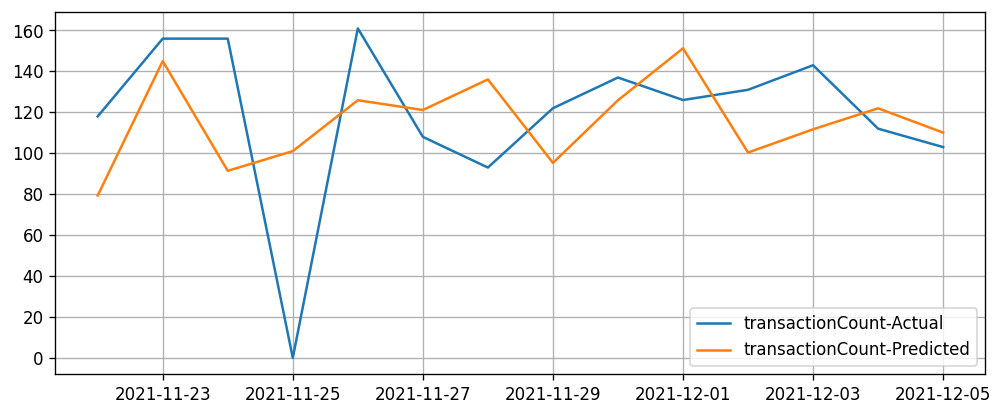

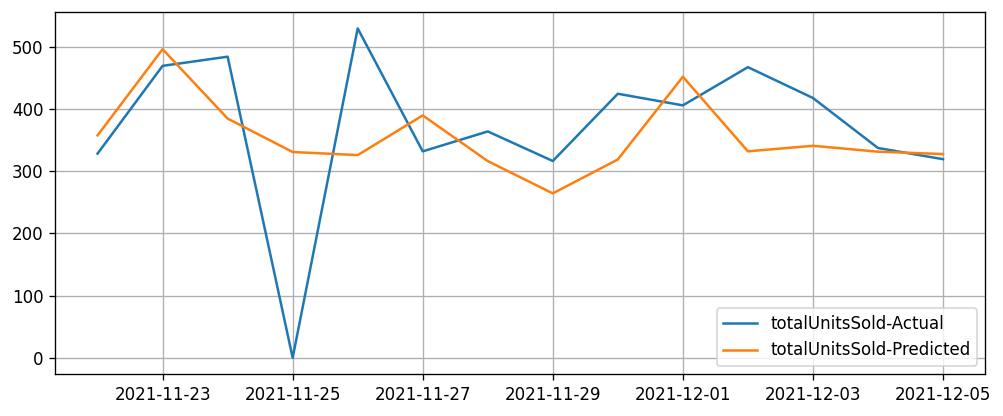

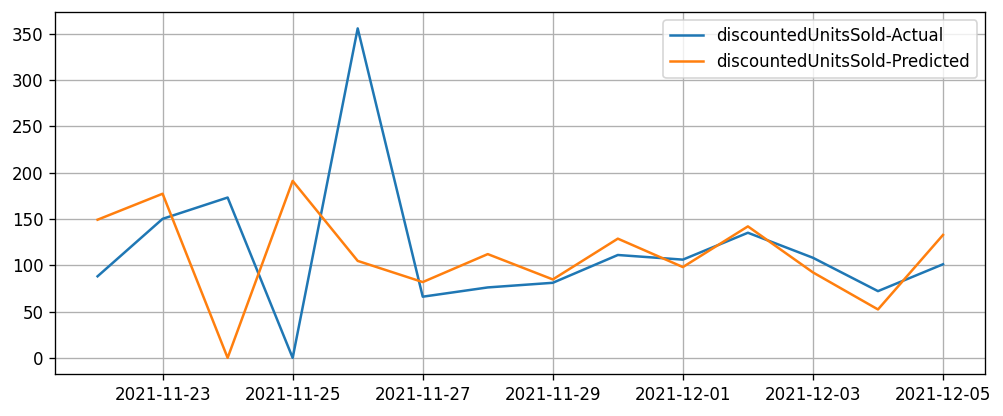

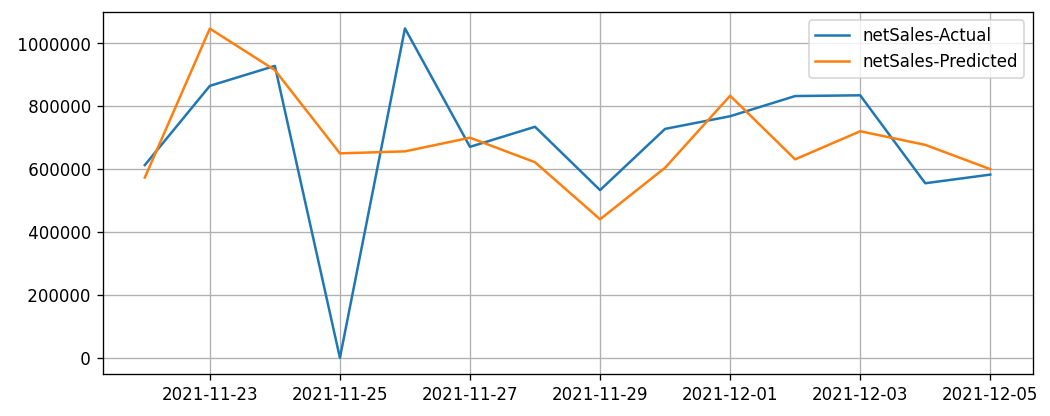

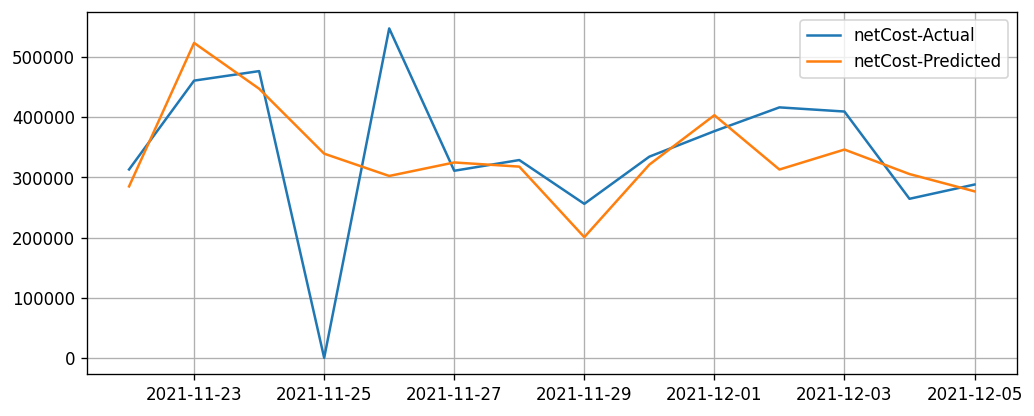

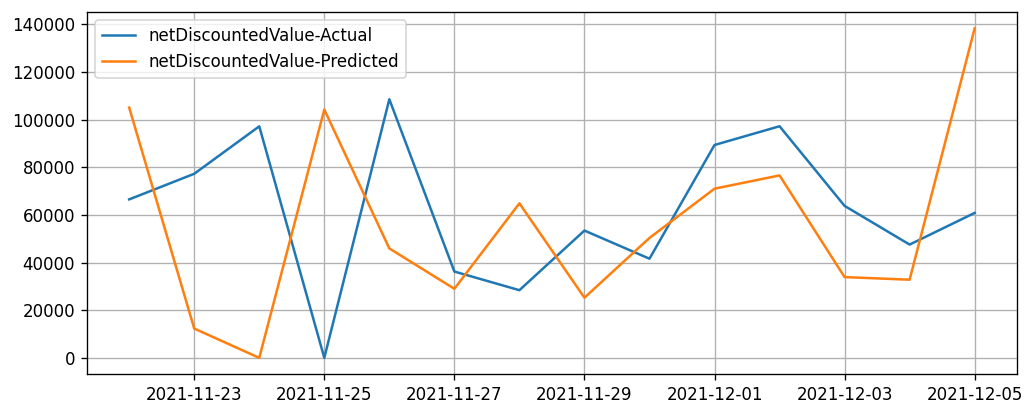

In [28]:

import matplotlib.ticker as ticker
x_data=['df1_test_full[cols[0]]','df2_test_full[cols[1]]','df3_test_full[cols[2]]',
        'df4_test_full[cols[3]]','df5_test_full[cols[4]]','df6_test_full[cols[5]]',]
y_data=['df1_test_forecast[cols[0]]','df2_test_forecast[cols[1]]','df3_test_forecast[cols[2]]',
        'df4_test_forecast[cols[3]]','df4_test_forecast[cols[4]]','df6_test_forecast[cols[5]]']

for i in range(0,6):
    x=eval(x_data[i])
    y=eval(y_data[i])

    fig1 = plt.figure(figsize=(10, 4), dpi=120)
    ax1 = fig1.add_subplot(111)
    ax1.plot(x,label=cols[i]+'-Actual')
    ax1.plot(y,label=cols[i]+'-Predicted')
    plt.grid()
    ax1.legend()
    if (i==3):
        ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('% 6.0f'))
        

## 2-Week Forecast
This is a forecast going 2-weeks forward following the end of the 100-day time period.

In [29]:
#%% copy the full data into a new frame and pad new dates for forecast
#14-day forecast
dts = pd.date_range(df.index[-1] + pd.offsets.DateOffset(1), df.index[-1]+pd.DateOffset(14))
df_2add = pd.DataFrame(data=np.nan, index=dts , columns=df.columns)
# blank data to add to the forecast
df_add=pd.concat([df, df_2add])
df_add_trend=pd.concat([df_trend, df_2add])
# DF to add only the trend
# go back to the linear trend model, and do  14 day linear trend

X = [i for i in range(len(df)-14, len(df))]
X_2weekplus = [i for i in range(len(df), len(df)+14)]
X = np.reshape(X, (len(X), 1))
X_2weekplus = np.reshape(X, (len(X_2weekplus), 1))
y = df.values[-14:]
model_2week = LinearRegression()
model_2week.fit(X, y)
# calculate trend
trend_2weekplus = model.predict(X_2weekplus)
# assign the new trends to the two weeks plus data
df_add_trend.iloc[-14:]=trend_2weekplus

# split the trend df into dfs suitable for each model
for i in range (0,len(candidate_vars_filter)):
    filt=candidate_vars_filter.loc[cols[i]].tolist()
    ind_var=cols[i]
    # filter to get animating vars
    vrs=list(compress(cols, filt))
    # prepend the original variable
    vrs.insert(0, ind_var)
    print('Variable',cols[i],':',vrs)
    if (i==0):
        df1_add_trend=df_add_trend[vrs]
    if (i==1):
        df2_add_trend=df_add_trend[vrs]
    if (i==2):
        df3_add_trend=df_add_trend[vrs]
    if (i==3):
        df4_add_trend=df_add_trend[vrs]
    if (i==4):
        df5_add_trend=df_add_trend[vrs]
    if (i==5):
        df6_add_trend=df_add_trend[vrs]
# add the trend numbers to the full trend DF
# get a 28 day forecast, 14 days within the 100 days and 14 days past, then cut out the first 
#set of 14 days to retain only the 14 days past 100
fc1_2weekplus = model1_fitted.forecast(y=forecast1_input, steps=28)
fc1_2weekplus=fc1_2weekplus[-14:]
fc2_2weekplus = model2_fitted.forecast(y=forecast2_input, steps=28)
fc2_2weekplus=fc2_2weekplus[-14:]
fc3_2weekplus = model3_fitted.forecast(y=forecast3_input, steps=28)
fc3_2weekplus=fc3_2weekplus[-14:]
fc4_2weekplus = model4_fitted.forecast(y=forecast4_input, steps=28)
fc4_2weekplus=fc4_2weekplus[-14:]
fc5_2weekplus = model5_fitted.forecast(y=forecast5_input, steps=28)
fc5_2weekplus=fc5_2weekplus[-14:]
fc6_2weekplus = model6_fitted.forecast(y=forecast6_input, steps=28)
fc6_2weekplus=fc6_2weekplus[-14:]
# create a data frame of the above data

df1_2week_forecast = pd.DataFrame(fc1_2weekplus, index=df_add_trend.index[-nobs:], columns=df1.columns )
df2_2week_forecast = pd.DataFrame(fc2_2weekplus, index=df_add_trend.index[-nobs:], columns=df2.columns )
df3_2week_forecast = pd.DataFrame(fc3_2weekplus, index=df_add_trend.index[-nobs:], columns=df3.columns )
df4_2week_forecast = pd.DataFrame(fc4_2weekplus, index=df_add_trend.index[-nobs:], columns=df4.columns )
df5_2week_forecast = pd.DataFrame(fc5_2weekplus, index=df_add_trend.index[-nobs:], columns=df5.columns )
df6_2week_forecast = pd.DataFrame(fc6_2weekplus, index=df_add_trend.index[-nobs:], columns=df6.columns )

# take the old trend df and extract the last 14 data points and add that to this df
df1_add_trend_short=df1_add_trend.iloc[-nobs:]
df2_add_trend_short=df2_add_trend.iloc[-nobs:]
df3_add_trend_short=df3_add_trend.iloc[-nobs:]
df4_add_trend_short=df4_add_trend.iloc[-nobs:]
df5_add_trend_short=df5_add_trend.iloc[-nobs:]
df6_add_trend_short=df6_add_trend.iloc[-nobs:]
# add the trend to the forecast
df1_2week_forecast = df1_2week_forecast.add(df1_add_trend_short, fill_value=0)
df2_2week_forecast = df2_2week_forecast.add(df2_add_trend_short, fill_value=0)
df3_2week_forecast = df3_2week_forecast.add(df3_add_trend_short, fill_value=0)
df4_2week_forecast = df4_2week_forecast.add(df4_add_trend_short, fill_value=0)
df5_2week_forecast = df5_2week_forecast.add(df5_add_trend_short, fill_value=0)
df6_2week_forecast = df6_2week_forecast.add(df6_add_trend_short, fill_value=0)


Variable transactionCount : ['transactionCount', 'netSales', 'netCost', 'netDiscountedValue']
Variable totalUnitsSold : ['totalUnitsSold', 'netSales', 'netCost', 'netDiscountedValue']
Variable discountedUnitsSold : ['discountedUnitsSold', 'netDiscountedValue']
Variable netSales : ['netSales', 'totalUnitsSold', 'netCost', 'netDiscountedValue']
Variable netCost : ['netCost', 'totalUnitsSold', 'netSales', 'netDiscountedValue']
Variable netDiscountedValue : ['netDiscountedValue', 'totalUnitsSold', 'discountedUnitsSold']


## Forecast plots

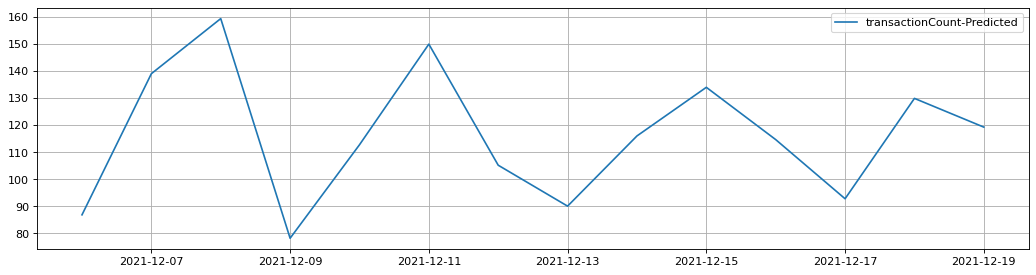

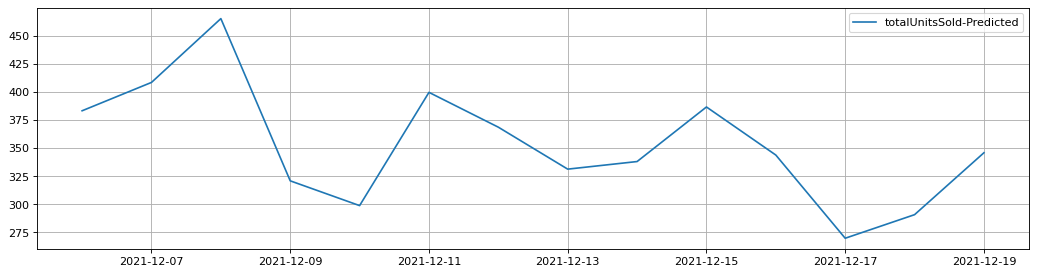

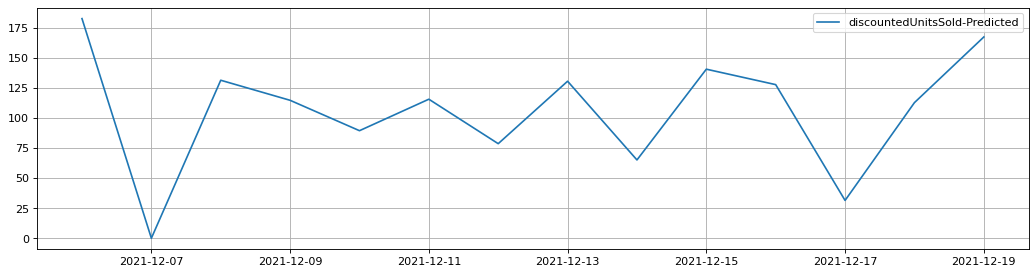

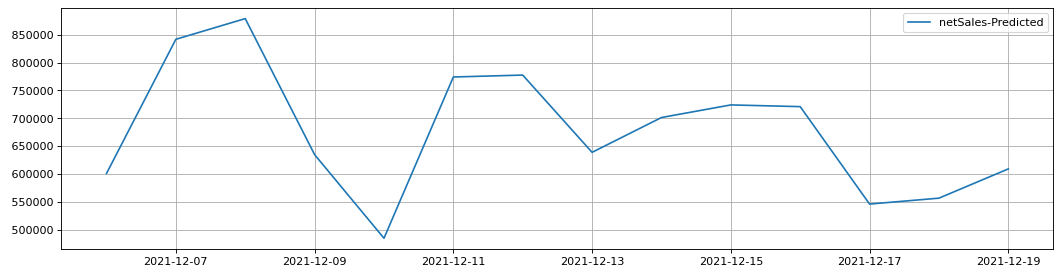

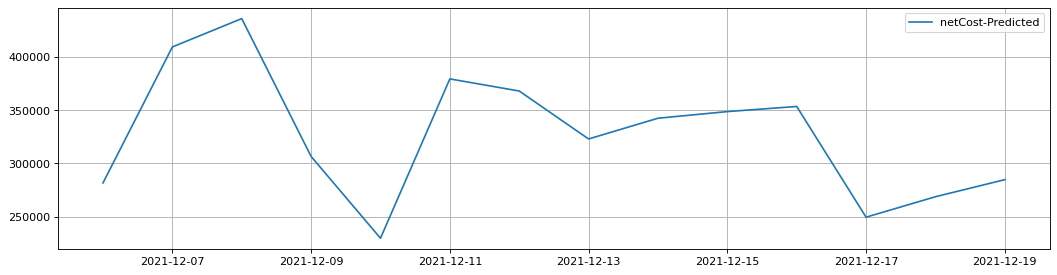

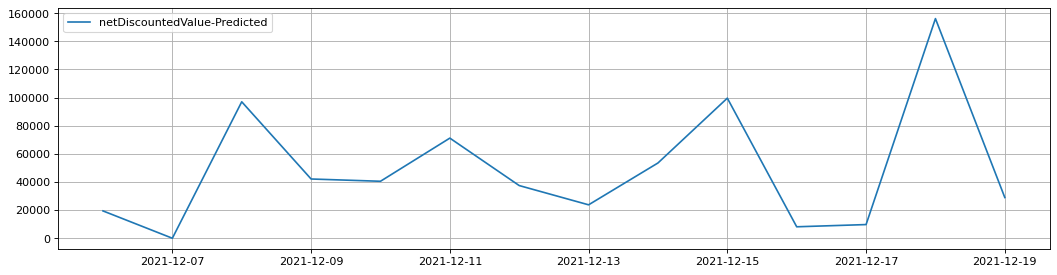

In [30]:

# first zero any negative values
df1_2week_forecast[df1_2week_forecast<0]=0
df2_2week_forecast[df2_2week_forecast<0]=0
df3_2week_forecast[df3_2week_forecast<0]=0
df4_2week_forecast[df4_2week_forecast<0]=0
df5_2week_forecast[df5_2week_forecast<0]=0
df6_2week_forecast[df6_2week_forecast<0]=0    

y_data=['df1_2week_forecast[cols[0]]','df2_2week_forecast[cols[1]]','df3_2week_forecast[cols[2]]',
        'df4_2week_forecast[cols[3]]','df5_2week_forecast[cols[4]]','df6_2week_forecast[cols[5]]',]

for i in range(0,6):
    y=eval(y_data[i])

    fig1 = plt.figure(figsize=(16, 4), dpi=80)
    ax1 = fig1.add_subplot(111)
    ax1.plot(y,label=cols[i]+'-Predicted')
    plt.grid()
    ax1.legend()
    if (i==3):
        ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('% 6.0f'))
        
